In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\SEO09\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (30,10)

In [13]:
class Coin:
    
    def __init__(self):
        self.coins = 'TRX,NEO,BLZ,ICX,EOS,VEN,XRP,ADA,XLM,FUN,BNB,DGD,LTC,IOTA,CTR,WTC,CND,QSP,OMG,PPT,ZRX,IOST,GXS,XVG,BQX,LSK,REQ,POWR,POE,ELF,QTUM,ENG,BTS,AION,XMR,VIBE,SNT,KNC,ETC,MANA,VIB,LEND,SUB,OST,SALT,ZEC,ENJ,NEBL,HSR,NULS,LINK,BCD,LRC,WABI,TNB,GTO,ARK,TRIG,DASH,APPC,STRAT,MTL,SNGLS,MDA,INS,GVT,TNT,AST,BAT,BTG,MCO,CDT,LUN,ARN,AMB,WAVES,ADX,FUEL,BRD,RCN,XZC,MOD,NAV,EVX,DNT,KMD,BNT,ICN,BCPT,STORJ,DLT,EDO,WINGS,SNM,MTH,OAX,YOYO'.split(',')
        self.coin_dict = {}
        for i in self.coins:
            self.coin_dict[i] = pd.read_csv('data_csv/data_{}_KRW.csv'.format(i)).drop(['Unnamed: 0'], axis = 1)

class Index:
    
    def __init__(self, coin_dict, my_coin = 'ETH'):
        self.coin_dict = coin_dict
        self.my_coin = my_coin.upper()
        
        self.close = np.array(self.coin_dict[self.my_coin].close) + np.array(10e-12)
        self.volumeto = np.array(self.coin_dict[self.my_coin.upper()].volumeto) + np.array(10e-12)

    def close_del(self, interval = 24):
        close = self.close
        del_list = [(close[i+interval]-close[i])*100/close[i] for i in range(len(close)-interval)] # 가격 변화율
        self.close_del = np.array(del_list)
        return np.array(del_list)
    
    def volume_del(self, interval = 24):
        volumeto = self.volumeto
        del_list = [(volumeto[i+interval]-volumeto[i])*100/volumeto[i] for i in range(len(volumeto)-interval)] # 거래량 변화율
        self.volume_del = np.array(del_list)
        return np.array(del_list)
    
    def close_std(self, interval = 24): # 가격 표준편차 표준화
        close = self.close
        std_list = [np.std(close[i:i+interval])*100/np.mean(close[i:i+interval]) for i in range(len(close)-interval)]
        self.close_std = std_list
        return np.array(std_list)
    
    def volume_std(self, interval = 24): # 가격 표준편차 표준화
        volumeto = self.volumeto
        std_list = [np.std(volumeto[i:i+interval])*100/np.mean(volumeto[i:i+interval]) for i in range(len(volumeto)-interval)]
        self.volume_std = std_list
        return np.array(std_list)
    
    def moving_avg(self, interval = 24): #이동평균선
        close = self.close
        avg_list = [np.mean(close[i:i+interval]) for i in range(len(close)-interval)]
        self.moving_avg = avg_list
        return np.array(avg_list)
    
    def moving_std(self, interval = 24): #이동표준편차
        close = self.close
        std_list = [np.std(close[i:i+interval]) for i in range(len(close)-interval)]
        self.moving_std = std_list
        return np.array(std_list)
    
    def bolin_up(self, interval = 24): #볼린저 위
        close = self.close
        bolup_list = [np.mean(close[i:i+interval]) + (2*np.std(close[i:i+interval])) for i in range(len(close)-interval)]
        self.bolin_up = np.array(bolup_list)
        return np.array(bolup_list)
    
    def bolin_dn(self, interval = 24): #볼린저 아래
        close = self.close
        boldn_list = [np.mean(close[i:i+interval]) - (2*np.std(close[i:i+interval])) for i in range(len(close)-interval)]
        self.bolin_dn = np.array(boldn_list)
        return np.array(boldn_list)
    

class Learn: # 머신러닝
    
    def __init__(self, hidden_dim = 20, seq_length = 24):
        self.hidden_dim = hidden_dim
        self.seq_length = 24
        
    def process(self, x, y):
        print('processing started')

        self.data_dim = x.shape[1]
        self.output_dim = y.shape[1]
        
        self.dataX = []
        self.dataY = []
        
        for i in range(len(y) - self.seq_length):
            _x = np.array(x)[i:i+self.seq_length]
            _y = np.array(y)[i]
            self.dataX.append(_x) # data with previous data
            self.dataY.append(_y) # label
        print('Data processed')

    def learn(self, trainX, trainY):
        
        
        self.X = tf.placeholder(tf.float32, [None, self.seq_length, self.data_dim])
        self.Y = tf.placeholder(tf.float32, [None,self.output_dim])
         
        cell = tf.contrib.rnn.BasicLSTMCell(num_units = self.hidden_dim, state_is_tuple = True)
        output, state = tf.nn.dynamic_rnn(cell, self.X, dtype = tf.float32)
        self.Y_pred = tf.contrib.layers.fully_connected(output[:,-1], self.output_dim, activation_fn = None)
        print('RNN initiated')
        
        loss = tf.reduce_sum(tf.square(self.Y_pred - self.Y))

        opt = tf.train.AdamOptimizer(0.01)
        train = opt.minimize(loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        print('initialized')
        
        for i in range(2000):
            tr, l = self.sess.run([train, loss], feed_dict = {self.X: trainX, self.Y: trainY})
            if i%100 == 0:
                print('cycle {} of 2000 done \r'.format(i))
                
        print('Learning Done!')

    def predict(self, testX):
        
        testPred = self.sess.run(self.Y_pred, feed_dict = {self.X: testX})
        print('Test data predicted')
        
        self.testPred = testPred
        return testPred

In [14]:
coins = Coin()

In [29]:
ada = Index(coins.coin_dict, 'ADA') # 인터벌은 각 지표마다 따로 넣는게 좋은 듯..

In [30]:
price_del = ada.close_del(interval = 1)[:1977]
volume_del = ada.volume_del(interval = 5)[:1977]
price_std = ada.close_std()
volume_std = ada.volume_std()

In [31]:
x = np.array([price_del, volume_del, price_std, volume_std]).T # 학습에 쓰이는 데이터
y = np.array([price_del]).T #답(24시간동안의 양상을 바탕으로 다음 1시간후(25시간)의 상승률)


In [33]:
ada_learn = Learn()

In [34]:
ada_learn.process(x,y)

processing started
Data processed


In [35]:
train_size = int(len(ada_learn.dataY) * 0.7)
test_size = len(ada_learn.dataY) - train_size

trainX, testX = np.array(ada_learn.dataX[0:train_size]), np.array(ada_learn.dataX[train_size:len(ada_learn.dataX)])
trainY, testY = np.array(ada_learn.dataY[0:train_size]), np.array(ada_learn.dataY[train_size:len(ada_learn.dataX)])

In [36]:
ada_learn.learn(trainX, trainY)

RNN initiated
initialized
cycle 0 of 2000 done 
cycle 100 of 2000 done 
cycle 200 of 2000 done 
cycle 300 of 2000 done 
cycle 400 of 2000 done 
cycle 500 of 2000 done 
cycle 600 of 2000 done 
cycle 700 of 2000 done 
cycle 800 of 2000 done 
cycle 900 of 2000 done 
cycle 1000 of 2000 done 
cycle 1100 of 2000 done 
cycle 1200 of 2000 done 
cycle 1300 of 2000 done 
cycle 1400 of 2000 done 
cycle 1500 of 2000 done 
cycle 1600 of 2000 done 
cycle 1700 of 2000 done 
cycle 1800 of 2000 done 
cycle 1900 of 2000 done 
Learning Done!


In [37]:

pred = ada_learn.predict(testX)

Test data predicted


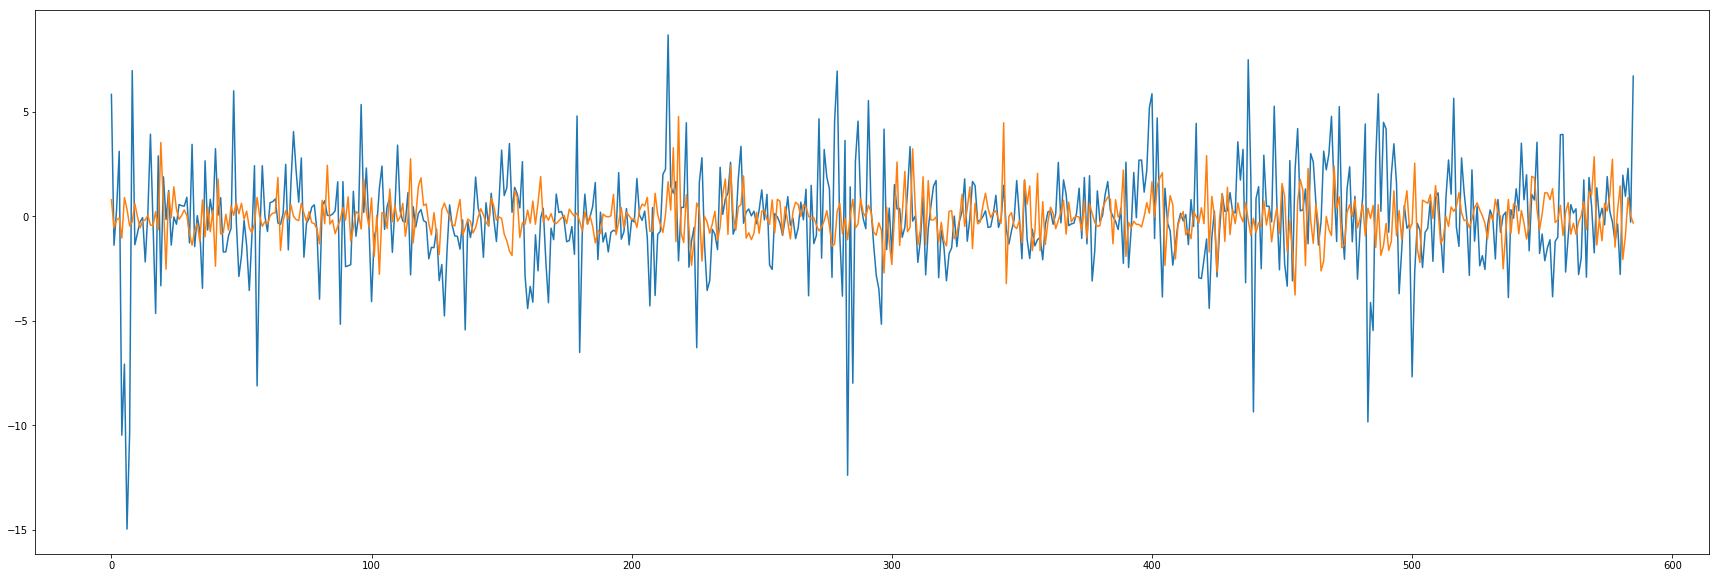

In [38]:
plt.plot(pred)
plt.plot(testY)
plt.show()

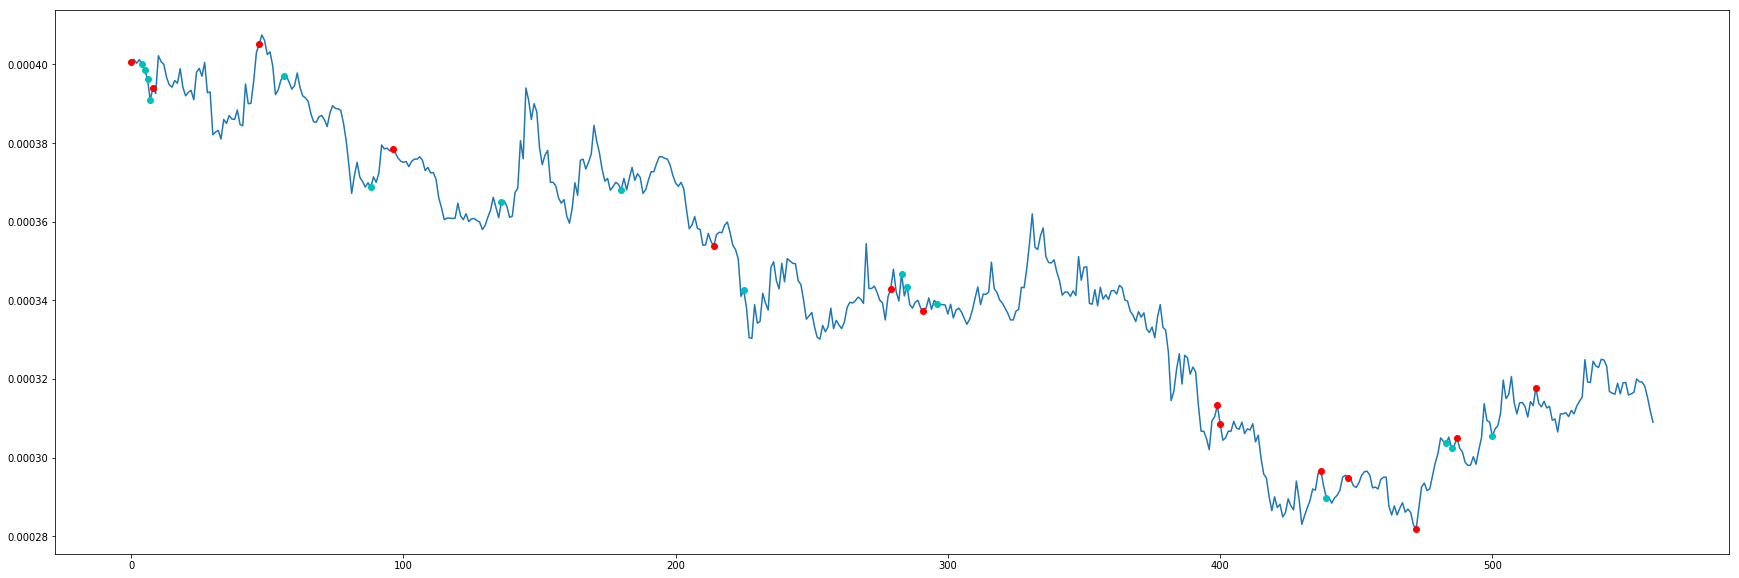

In [40]:
ada_price = ada.close[-560:]
plt.plot(ada_price) # blue
buy = [ada_price[i] if pred[i] > 5 else None for i in range(len(ada_price)) ] # red # 10퍼증가할 확률 큰 지점
sell = [ada_price[i] if pred[i] < -5 else None for i in range(len(ada_price)) ] # cyan # 5퍼 떨어질 확률 큰 지점
plt.plot(buy, 'ro')
plt.plot(sell, 'co')
plt.show() 